# Assignment 1: Plotting grad-CAM images of any 50 misclassified objects of cifar10 dataset.

**Objective:** Use pretrained resnet18 model (trained with imagenet dataset).

**Procedure:** Use the pretrained resnet18 model trained on imagenet dataset. I took the model from the source: 

https://github.com/qubvel




In [1]:
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D, Input, Add
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import *

from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator 

import sys

from skimage import io
from skimage import transform
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
import random
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !ls '/content/gdrive/My Drive/'
!mkdir ~/.keras/datasets
!cp '/content/gdrive/My Drive/cifar-10-python.tar.gz' ~/.keras/datasets/cifar-10-batches-py.tar.gz

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
x_train = train_features
y_train = train_labels
x_test = test_features
y_test = test_labels

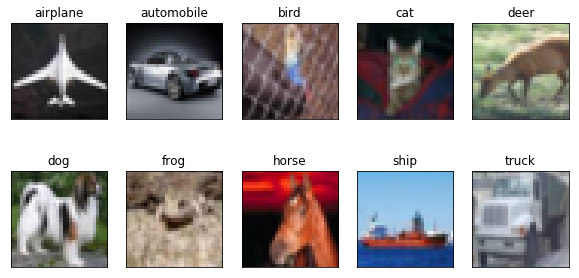

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
class_labels = list(range(10))
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# This cell is to generate random indices for train and test data -- to demonstrate the implementation of gradCAM
# This selection is based on the class labels
import random

train_set_f = [np.where(train_labels[:] == i) for i in class_labels]
test_set_f = [np.where(test_labels[:] == i) for i in class_labels]
train_set_features = [train_set_f[i][0] for i in class_labels]
test_set_features = [test_set_f[i][0] for i in class_labels]

clabels = random.choices(class_labels, k=2)
train_c = [random.choices(train_set_features[i], k=1) for i in clabels]
clabels = random.choices(class_labels, k=2)
test_c = [random.choices(test_set_features[i], k=1) for i in clabels]
train_clist = [item for sublist in train_c for item in sublist]
test_clist = [item for sublist in test_c for item in sublist]

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/eip3ph2/assignments/a1_resnet/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=3)

In [0]:
weight_decay=1e-7
space_dropout = 0.125
px_dropout=0.2
lr_initial = 0.000005

In [0]:
def scheduler(epoch, lr):
  
  if lr > 9e-7:
    learn_rate = round(lr/(1 + 0.0025 * epoch), 9)
    return learn_rate
  else:
    start  = lr_initial / 10
    learn_rate = round(start/(1 + 0.0025 * epoch), 9)
    return learn_rate

lr_schedule = LearningRateScheduler(scheduler, verbose=1)

In [15]:
batch_size = 125
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
train_generator = train_datagen.flow(train_features, train_labels, batch_size, shuffle=True)
train_datagen.fit(train_features)
train_datagen.mean, train_datagen.std

(array([[[125.3069 , 122.95015, 113.866  ]]], dtype=float32),
 array([[[62.993256, 62.08861 , 66.705   ]]], dtype=float32))

In [0]:
test_datagen = ImageDataGenerator()
# test_features = (test_features - train_datagen.mean) / (train_datagen.std + 1e-7)
test_generator = test_datagen.flow(test_features, test_labels, batch_size, shuffle=False)
test_steps = test_generator.n // test_generator.batch_size

In [17]:
test_steps, batch_size, train_generator.n // train_generator.batch_size

(80, 125, 400)

In [18]:
# train_generator.reset, test_generator.reset
test_steps, np.ceil(len(test_features)/batch_size)

(80, 80.0)

In [0]:
# !pip install git+https://github.com/qubvel/classification_models.git
from classification_models.resnet import ResNet18, preprocess_input

In [0]:
def build_model(number_of_classes=num_classes):
  import keras
  base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
  print('Base model input_shape: ', base_model.input.shape)
  print('Base model output_shape: ', base_model.output.shape)
  base_input = base_model.input
  x1 = base_model.output
  
  x = Dense(10, name='Dense_customAdded')(x1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2D(num_classes, (1, 1), use_bias=False, name='conv_Layer_customAdded', kernel_regularizer=l2(weight_decay))(x)
  
  x = GlobalAveragePooling2D()(x)
  predictions = Activation('softmax')(x)
  model = Model(inputs=[base_input], output=[predictions])
  
  return base_model, model

In [124]:
base_model, model = build_model(10)

Base model input_shape:  (?, 32, 32, 3)
Base model output_shape:  (?, 1, 1, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
# Freeze the base_model layers as we want to keep those weights as it is, and only fine-tune the model weights at the last layer
  for i, layer in enumerate(model.layers):
    if i < 75:
      layer.trainable = False
    else:
      layer.trainable = True

In [0]:
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
for i, layer in enumerate(base_model.layers):
  print(i,"   ", layer.name)

In [0]:
import pydot
pydot.find_graphviz = lambda: True
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='{}.pdf'.format(model))

In [0]:
!cp '<keras.engine.training.Model object at 0x7f0ca297ada0>.pdf' /content/gdrive/'My Drive'/

In [127]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_199 (ZeroPadding (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_199[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
# Compile the model
model.compile(optimizer=Adam(lr = lr_initial), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 5e-06.
400/400 [==============================] - 19s 47ms/step - loss: 2.5589 - acc: 0.1171 - val_loss: 2.6091 - val_acc: 0.0903

Epoch 00001: val_acc did not improve from 0.44020
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 4.988e-06.
400/400 [==============================] - 10s 24ms/step - loss: 2.3945 - acc: 0.1428 - val_loss: 2.5033 - val_acc: 0.0945
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 4.963e-06.
400/400 [==============================] - 10s 24ms/step - loss: 2.3016 - acc: 0.1607 - val_loss: 2.4286 - val_acc: 0.1011
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 4.926e-06.
400/400 [==============================] - 9s 24ms/step - loss: 2.2300 - acc: 0.1797 - val_loss: 2.3827 - val_acc: 0.1111

Epoch 00004: val_acc did not improve from 0.44020
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 4.877e-

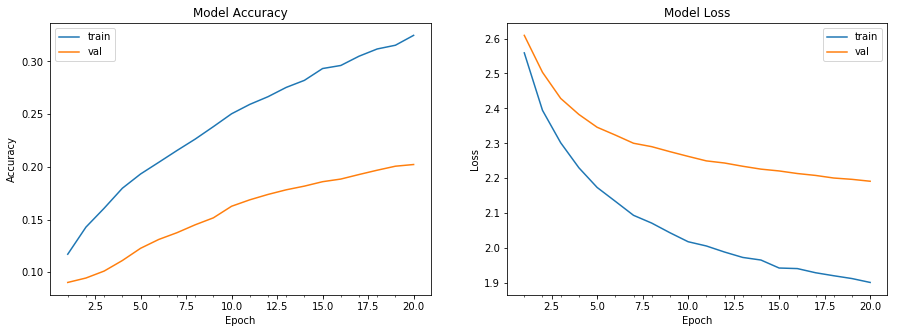

Accuracy on test data is: 20.22


In [129]:
# Model Execution is commented out to avoid re-running the model with same ('everything') architecture and parameters

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_generator, shuffle=True,
                                 steps_per_epoch = len(train_features)//batch_size, epochs = 20, 
                                 validation_data = test_generator, validation_steps = test_steps, callbacks = [lr_schedule, checkpoint], verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


In [0]:
model.load_weights("/content/gdrive/My Drive/eip3ph2/assignments/a1_resnet/weights-improvement-05-0.44.hdf5")

In [130]:
model.evaluate_generator(generator=test_generator, steps=test_steps)

[2.191552171111107, 0.20220000203698874]

In [0]:
# Helper functions
# preprocess_data() takes data ('train' or 'test') and num_idx (list of indices of data for which the grad-CAM is to be generated)
# preprocess_data() will only standardize the data, and outputs the standardized data along with the true labels for the given data.
# For convenience of identifying which data (train or test and what is the index) we used, it will also output the 
# datagroup (train/test) and set_data (those data selected from num_idx)


def preprocess_data(data, num_idx):
  if data == 'train':
    set_data = [x_train[i] for i in num_idx]
    true_labels = [y_train[i] for i in num_idx]
  elif data == 'test':
    set_data = [x_test[i] for i in num_idx]
    true_labels = [y_test[i] for i in num_idx]
  else:
    print("Wrong input to preprocess_data function. Input either 'train' or 'test' for data.")
    
  x = [np.expand_dims(i, axis=0) for i in set_data]
  # print([x[i].shape for i in range(len(num_idx))])
  x_stzd = [(i - train_datagen.mean) / (train_datagen.std + 1e-7) for i in x]
  true_labels = np.array(true_labels).tolist()
  true_labels = [item for sublist in true_labels for item in sublist]
  # xbar = np.concatenate(x_stzd, axis=0)
  return (data, set_data, x_stzd, true_labels)

# heatmap_calculate() takes the class_output (containing outputs specific to the predicted class), layer name (for which the heatmaps are to be generated), and the standardized data (output from preprocess_data())

def heatmap_calculate(class_output, calc_layer, xb):
  # class_output is the model.output results for the class predicted (for test_features) or the class (train_features)
  # calc_layer is the layer where the heatmap is calculated at. Entered as a string.
  # Usage: heatmap_calculate(class_output, "out_layer2")
  last_conv_layer = model.get_layer(calc_layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  # print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  pg_channels = pooled_grads.shape[0]
  # print(pooled_grads.shape, pg_channels)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  
  pooled_grads_value, conv_layer_output_value = iterate([xb])
  
  for i in range(pg_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  # print(conv_layer_output_value.shape)
  # print(heatmap.shape)
  heatmap = np.maximum(heatmap, 1e-14)
  heatmap /= np.max(heatmap)
  return heatmap

In [132]:
datagroup, x_d, x_st, true_labels = preprocess_data('test', range(x_test.shape[0]))
test_generator.reset()
preds = model.predict_generator(generator=test_generator, steps = test_steps)
class_idx = [np.argmax(preds[i]) for i in range(x_test.shape[0])]
test_misclassified_labels = np.where(np.asarray(class_idx) != np.asarray(true_labels))[0]
print(1 - (test_misclassified_labels.shape[0] / 10000))

0.20220000000000005


These are the indices of 50 randomly selected test images (labels):  [8535 4443 1994 6209 7204 1310 7888 6469 6139 5999 1249 4156 6628 9509
 2211 6186 1175 4084 9791 3340 7319 7317 3997 8116 4056 8539 2195 4210
 2170  958 6534 7824 8404  996 1360 5528 7396 8597 7463 7753 6308 3741
 1601 5278 6656 1296 6210 9705 7969 2003]
The table below shows the grad-CAM implementation on CIFAR-10 images:


These are 50 randomly misclassified test images. The true-labels and misclassified labels are shown on top of each image



 Original image  	 	 Heatmaps 	 	 grad-CAM implemented image

 (with class label on top) 	 (gradCAM) 	 	 (with perdicted class label on top)


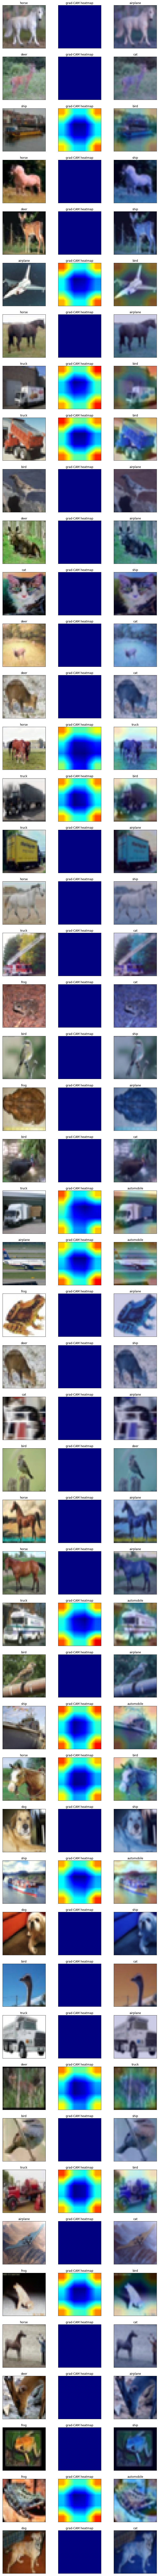

In [134]:
# This section will take inputs for implementation of grad-CAM on test dataset

ls_test = random.sample(list(test_misclassified_labels), 50)
print('These are the indices of 50 randomly selected test images (labels): ', np.array(ls_test))

datagroup, x_d, x_st, true_labels = preprocess_data('test', ls_test)

# preds = [model.predict(i) for i in x_st]
class_idx = [np.argmax(preds[i]) for i in ls_test]
class_output = [model.output[:, j] for j in class_idx]


heatmap_inputs = zip(class_output, x_st)

hmaps = [heatmap_calculate(cop, 'stage2_unit2_conv1', xb) for (cop, xb) in heatmap_inputs]
hmaps_rs = [cv2.resize(i, (200, 200)) for i in hmaps]
hmaps_rs = [np.uint8(255 * hs) for hs in hmaps_rs]
hmaps_rs = [cv2.applyColorMap(hs, cv2.COLORMAP_JET) for hs in hmaps_rs]
# [cv2_imshow(hs) for hs in hmaps_rs]

superimposed_test = [cv2.addWeighted(cv2.resize(x_d[i][:,:,::-1], (200, 200)), 0.8, hmaps_rs[i], 0.2, 0) for i in range(len(ls_test))]
# [cv2_imshow(superimposed_img[i]) for i in range(len(num_idx))]

fig = plt.figure(figsize=(12,4*len(ls_test)))

j = 1

print('The table below shows the grad-CAM implementation on CIFAR-10 images:')
print('\n')
print('These are 50 randomly misclassified test images. The true-labels and misclassified labels are shown on top of each image')
print('\n')
print('\n Original image  \t \t Heatmaps \t \t grad-CAM implemented image')
print('\n (with class label on top) \t (gradCAM) \t \t (with perdicted class label on top)')

for i in range(len(ls_test)):
  ax1 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax1.set_title(class_names[true_labels[i]])
  plt.imshow(x_d[i], 'jet')
  j = j + 1
  ax2 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax2.set_title('grad-CAM heatmap')
  plt.imshow(hmaps_rs[i], 'jet')
  j = j + 1
  ax3 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax3.set_title(class_names[class_idx[i]])
  plt.imshow(superimposed_test[i], 'jet')
  j = j + 1

# plt.tight_layout()
plt.show()

**Observation:** Some of the grad-CAM heatmaps obtained were plain bluish color. In my understanding this refers to the gradCAM getting no positive gradient values in the back propagation (that were attached to the object class).